In [1]:
import pandas as pd
import datetime as dt
from keras.models import Model, load_model
from keras.layers import LSTM, Dense, Input, Dropout, Activation
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('./20070720-20170831_day-ahed_hourly_market-clearing-price.csv', parse_dates=True, index_col=0)

In [3]:
any(data.index.to_series().diff() > dt.timedelta(hours=1))

False

In [4]:
q75 = data['DA_mcp'].quantile(.75)
q25 = data['DA_mcp'].quantile(.25)
IQR = q75 - q25

In [5]:
data['DA_mcp'] = data['DA_mcp'].apply(lambda x: q75 + 3 * IQR if (x > q75 + 3 * IQR) else x)
data['DA_mcp'] = data['DA_mcp'].apply(lambda x: q25 - 3 * IQR if (x < q75 - 3 * IQR) else x)

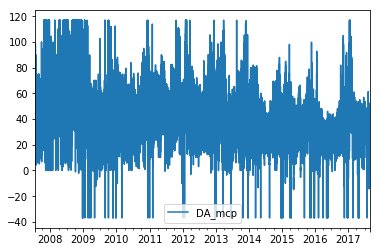

In [6]:
data.plot()

In [6]:
data_scaled = pd.DataFrame(index=data.index)
scaler = MinMaxScaler()
data_scaled['DA_mcp'] = scaler.fit_transform(data)

In [7]:
for lag in range(1, 168 + 1):
    data_scaled[lag] = data_scaled['DA_mcp'].shift(lag)

In [8]:
data_scaled.dropna(inplace=True)

In [9]:
labels = data_scaled['DA_mcp'].as_matrix().reshape(-1, 1)

In [10]:
data_scaled.drop('DA_mcp', axis=1, inplace=True)

In [12]:
features = data_scaled.as_matrix()

In [13]:
test_len = len(pd.date_range(dt.datetime(2017, 1, 1), data.index[-1], freq='1H'))

In [14]:
X_train, X_test = features[:-test_len], features[-test_len:]
y_train, y_test = labels[:-test_len], labels[-test_len:]

In [57]:
X_test.shape[0]/24

243.0

In [58]:
X_train.shape[0]/24

3446.0

In [60]:
y_train.shape

(82704, 1)

In [61]:
X_train_LSTM = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_LSTM = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [373]:
input_layer = Input(shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2]))
x = LSTM(64)(input_layer)
# x = LSTM(32, return_sequences=True)(x)
# x = LSTM(32)(x)
x = Dense(1)(x)

In [374]:
model = Model(inputs=[input_layer], outputs=[x])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 168, 1)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [375]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [376]:
checkpointer = ModelCheckpoint('./{}_1step_TS-only_simple.hdf5'.format(dt.date.today()), save_best_only=True)
model.fit(X_train_LSTM, y_train, validation_data=(X_test_LSTM, y_test), verbose=1, epochs=5, batch_size=500,
          callbacks=[checkpointer])

Train on 82704 samples, validate on 5832 samples
Epoch 1/5


KeyboardInterrupt: 

In [66]:
pred = model.predict(X_test_LSTM)

In [67]:
results = pd.DataFrame({'pred':pred.flatten(), 'true':y_test.flatten()})

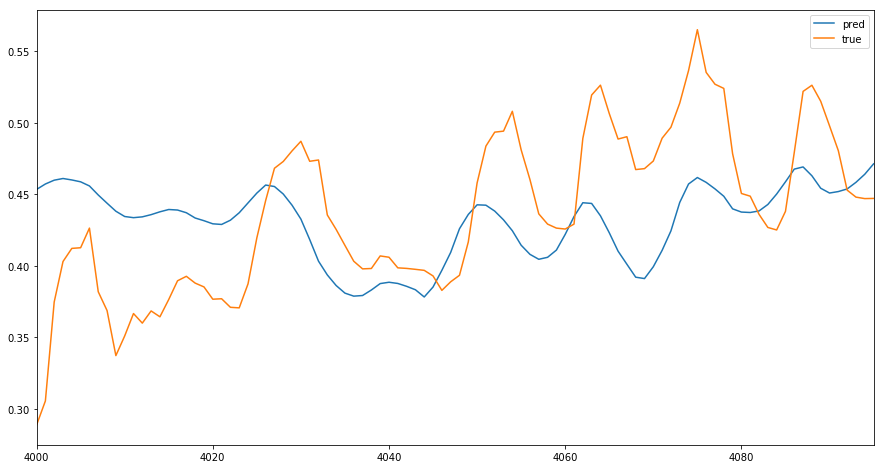

In [68]:
results.iloc[4000:4096].plot(figsize=(15, 8))

# 24 hour direct prediction 

In [11]:
new_features = data_scaled[data_scaled.index.hour == 0].as_matrix()

In [12]:
new_features_LSTM = new_features.reshape(new_features.shape[0], new_features.shape[1], 1)

In [13]:
new_labels = []
for i in range(0, labels.shape[0], 24):
    new_labels.append(labels[i:i+24].reshape(24))

In [14]:
new_labels = np.array(new_labels)

In [15]:
new_features_LSTM.shape, new_labels.shape

((3689, 168, 1), (3689, 24))

In [76]:
input_layer = Input(shape=(new_features_LSTM.shape[1], new_features_LSTM.shape[2]))
x = LSTM(32, return_sequences=True, recurrent_activation='relu')(input_layer)
# x = LSTM(12)(x)
x = LSTM(32)(x)
x = Dense(24)(x)

In [77]:
model = Model(inputs=[input_layer], outputs=[x])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 168, 1)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 168, 32)           4352      
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                792       
Total params: 13,464
Trainable params: 13,464
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

checkpointer = ModelCheckpoint('./{}_24step_TS-only_simple.hdf5'.format(dt.date.today()), save_best_only=True)
model.fit(new_features_LSTM, new_labels, verbose=1, epochs=4, batch_size=100,
          callbacks=[checkpointer])

In [84]:
pred = model.predict(new_features_LSTM)

In [28]:
data['pred_last_day'] = data['DA_mcp'].shift(24)

In [29]:
for lag in range(24*7, 24*7*5, 24*7):
    data['lag_{}'.format(lag)] = data['DA_mcp'].shift(lag)

In [30]:
data['pred_last_week'] = data['DA_mcp'].shift(24*7)

In [31]:
data.columns

Index(['DA_mcp', 'pred_last_day', 'lag_168', 'lag_336', 'lag_504', 'lag_672',
       'pred_last_week'],
      dtype='object')

In [32]:
data['pred_avg_weekday'] = data[['lag_168', 'lag_336', 'lag_504', 'lag_672']].mean(axis=1)

In [33]:
len(pred.flatten()) - len(data.dropna())

504

In [34]:
len(pred.flatten()[504:])

88032

In [35]:
len(data.dropna())

88032

In [36]:
data.dropna(inplace=True)

In [85]:
data['pred_model'] = scaler.inverse_transform(pred.flatten()[504:].reshape(-1, 1))

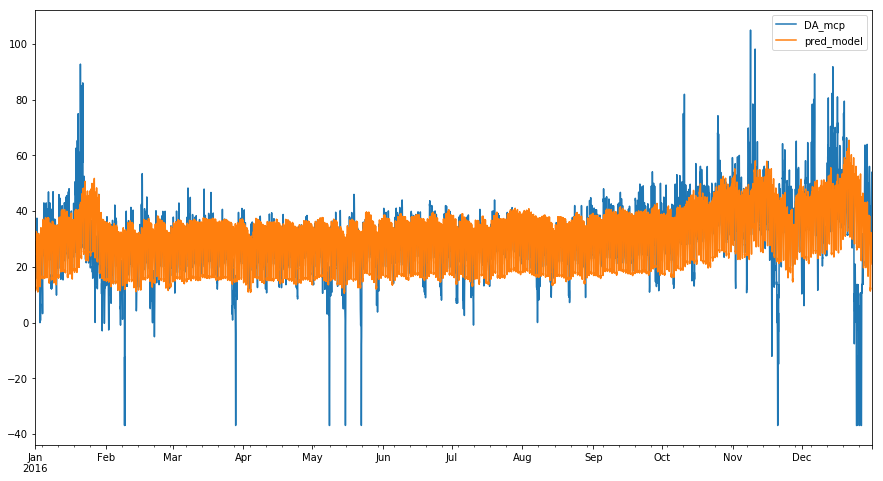

In [91]:
data.loc["2016", ['DA_mcp', 'pred_model']].plot(figsize=(15, 8))

In [36]:
print(mean_absolute_error(y_pred=data['pred_avg_weekday'], y_true=data['DA_mcp']))

7.86853645265


In [87]:
print(mean_absolute_error(y_pred=data['pred_model'], y_true=data['DA_mcp']))

8.63962285153


In [38]:
print(mean_absolute_error(y_pred=data['pred_last_day'], y_true=data['DA_mcp']))

8.7568197928


In [39]:
print(mean_absolute_error(y_pred=data['pred_last_week'], y_true=data['DA_mcp']))

8.64627240095


### Convolutional approach

In [135]:
test_len = len(pd.date_range(dt.datetime(2017, 1, 1), data.index[-1], freq='1H')) // 24

In [136]:
test_len

243

In [137]:
X_train, X_test = new_features_LSTM[:-test_len], new_features_LSTM[-test_len:]
y_train, y_test = new_labels[:-test_len], new_labels[-test_len:]

In [146]:
input_layer = Input(shape=(168,1))
x = Conv1D(64, kernel_size=24, strides=24, padding='same')(input_layer)
x = LSTM(32, return_sequences=True, recurrent_activation='relu')(x)
x = LSTM(32, recurrent_activation='relu')(x)
x = Dense(24)(x)
model = Model(inputs=[input_layer], outputs=[x])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 168, 1)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 7, 64)             1600      
_________________________________________________________________
lstm_18 (LSTM)               (None, 7, 32)             12416     
_________________________________________________________________
lstm_19 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_12 (Dense)             (None, 24)                792       
Total params: 23,128
Trainable params: 23,128
Non-trainable params: 0
_________________________________________________________________


In [147]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

checkpointer = ModelCheckpoint('./{}_conv_LSTM.hdf5'.format(dt.date.today()), save_best_only=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=1, epochs=100, batch_size=10,
          callbacks=[checkpointer])

Train on 3446 samples, validate on 243 samples
Epoch 1/100
3446/3446 [==============================] - 7s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1117 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0583
Epoch 2/100
3446/3446 [==============================] - 3s - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0585 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0652
Epoch 3/100
3446/3446 [==============================] - 3s - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0579 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0575
Epoch 4/100
3446/3446 [==============================] - 4s - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0560 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0550
Epoch 5/100
3446/3446 [==============================] - 4s - loss: 0.005

3446/3446 [==============================] - 6s - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0402 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0401
Epoch 38/100
3446/3446 [==============================] - 5s - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0397 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0391
Epoch 39/100
3446/3446 [==============================] - 4s - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0400 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0527
Epoch 40/100
3446/3446 [==============================] - 4s - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0403 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0401
Epoch 41/100
3446/3446 [==============================] - 5s - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0

3446/3446 [==============================] - 3s - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0375 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0384
Epoch 75/100
3446/3446 [==============================] - 3s - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0372 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0374
Epoch 76/100
3446/3446 [==============================] - 3s - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0369 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0392
Epoch 77/100
3446/3446 [==============================] - 3s - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0374 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0389
Epoch 78/100
3446/3446 [==============================] - 3s - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0

In [148]:
model = load_model('./2017-10-04_conv_LSTM.hdf5')

In [149]:
pred = model.predict(new_features_LSTM)

In [150]:
data['pred_model_conv'] = scaler.inverse_transform(pred.flatten()[504:].reshape(-1, 1))

In [151]:
print(mean_absolute_error(y_pred=data['pred_model_conv'], y_true=data['DA_mcp']))

5.41194686503


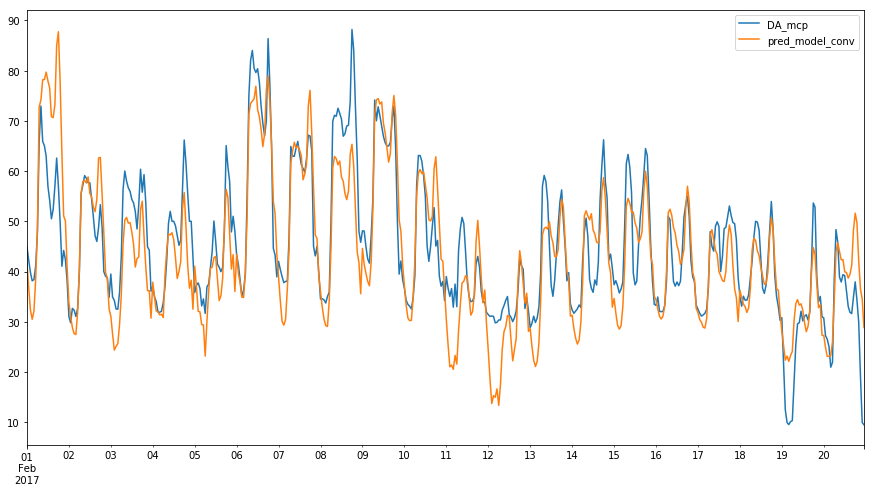

In [153]:
data.loc["2017-2":'2017-2-20', ['DA_mcp', 'pred_model_conv']].plot(figsize=(15, 8))

In [129]:
model = load_model('./2017-10-04_conv_LSTM_try.hdf5')

In [133]:
pred = model.predict(new_features_LSTM)